## Introduction

In this exercise, classification models will be used to answer what factors lead to employee attrition in the Healthcare industry. The dataset used is a Kaggle dataset which can be found [here.](https://www.kaggle.com/code/emirhanaydn/eda-and-ml-randomforest-predict-93/data)

### Sections

* [Importing Packages and Loading Data](#importing-packages-and-loading-data)
* [Data Cleaning](#data-cleaning)
    * [Duplicate and Nulls](#duplicate-nulls)
    * [Unique Values](#unique_values)
    * [Converting Numbers to Strings](#converting)
* [Plotting](#plotting)
    * [Boxplot](#boxplots)
    * [Histograms](#histograms)
    * [Countplots](#countplots)
* [Exploratory Data Analysis](#eda)
* [Modeling](#modeling)
    * [Logistic](#lr)
    * [Random Forest](#rf)
    * [Extra Trees](#et)
    * [Gradient Boosting](#gbm)
    * [XGBoost](#xgb)
* [Conclusion](#conclusion)

<h2>Importing Packages and Loading Data <a id = "importing-packages-and-loading-data" class="anchor"></a></h2>

In [71]:
import pandas as pd
import numpy as np
import os
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.patches as mpatches
sns.set_theme(style="dark")


import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [2]:
path = os.getcwd() + '/Data/'

filename = [f for f in os.listdir(path) if '.csv' in f][0]
df = pd.read_csv(path + filename,low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   object
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   object
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement            1676 non-null   int64 
 14  JobLevel                

In [3]:
df.head()

,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


<h2>Data Cleaning <a id = "data-cleaning" class="anchor"></a></h2>
In this section we will perform any data cleaning that we might need, such as filling in nulls (or removing the observation), finding columns with only one unique value, converting some columns from number datatype to string datatype

### Evaluation of Fields

In this section we will investigate fields in this data set, to see if there are any null values, the uniqueness of each field, and to gauge if these will be suitable for our model in the later section


#### * Nulls

As seen below, there are no missing values for any of the fields, thus no need to fill in any missing values

In [4]:
cols_cat = [x for x in df if df[x].dtype=='object']
cols_drop = []
dfc = df.copy()

In [5]:
mv = dfc.isnull().sum().sort_values(ascending=False).to_frame('Missing Values')
mv['% missing'] = round(mv['Missing Values']/df.shape[0]*100)
mv = mv.merge(df.nunique().to_frame('Unique Values'),right_index=True,left_index=True).sort_index()
describe = df.describe().T
mv = mv.merge(describe,how='left',left_index=True,right_index=True)
mv.loc[mv['count'].notnull(),'Type'] = 'number'
mv['Type'].fillna('string',inplace=True)
mv['mean'] = mv['mean'].round(3)

In [6]:
mv1 = mv.copy()
# Fields that are integer and have less than 7 unique values -> Categorical
col_num_to_string = list(mv1[(mv1['Type']=='number') & (mv1['Unique Values']<7)].index)
col_num_to_string.append('EmployeeID')
mv1.loc[col_num_to_string,[i for i in describe]] = np.nan
mv1.loc[col_num_to_string,'Type'] = 'string'

cols_number = mv1[mv1['Type']=='number'].index

mv1

,Missing Values,% missing,Unique Values,count,mean,std,min,25%,50%,75%,max,Type
Age,0,0.0,43,1676.0,36.866,9.129126,18.0,30.00,36.0,43.00,60.0,number
Attrition,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
BusinessTravel,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
DailyRate,0,0.0,886,1676.0,800.558,401.594438,102.0,465.00,796.5,1157.00,1499.0,number
Department,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
DistanceFromHome,0,0.0,29,1676.0,9.222,8.158118,1.0,2.00,7.0,14.00,29.0,number
Education,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
EducationField,0,0.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
EmployeeCount,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
EmployeeID,0,0.0,1676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string


##### Rate Columns
Do we need all the rate columns: Hourly, Daily, Monthly? Will they be correlated with each other? From below, it does not look like they are highly correlated, in fact we see some negative correlation which does not make sense. We will most likely keep all 3.

In [7]:
df[[x for x in df if 'Rate' in x]].corr()

,DailyRate,HourlyRate,MonthlyRate
DailyRate,1.000000,0.027128,-0.032211
HourlyRate,0.027128,1.000000,-0.025597
MonthlyRate,-0.032211,-0.025597,1.000000


#### * Unique Values
There are values where there is only one missing value, lets look at those. Since these fields have only one unique value, this does not add any information to any analysis we might do

In [8]:
print ('The following fiels have only 1 unique value:')
for i in mv[mv['Unique Values']==1].index:
    cols_drop.append(i)
    print (' ',i,':',df[i].unique())

The following fiels have only 1 unique value:
  EmployeeCount : [1]
  Over18 : ['Y']
  StandardHours : [80]


In [9]:
print ('The following fiels have only 2 unique value:')
for i in mv[mv['Unique Values']==2].index:
    print (' ',i,':',df[i].unique())

The following fiels have only 2 unique value:
  Attrition : ['No' 'Yes']
  Gender : ['Female' 'Male']
  OverTime : ['Yes' 'No']
  PerformanceRating : [3 4]


For the fields with two unique values, only one does not make sense, which is performance rating, which is either 3 or 4. We might convert his to a field that is "performance rating 4" and it is either 1 (if its 4) or 0 (if its 3). Same goes for other binary variables: Overtime, Attrition (dependent variable), and Gender.

#### * Converting Some Integer Columns to Strings
#### * Turning Dependent Variable into Binary

For the dependent variable, Attrition, we need to turn from True/False to 1 or 0

In [10]:
df1 = df.copy()
# Converting these columns from integer to string
df1[col_num_to_string] = df1[col_num_to_string].applymap(str)
df1 = df1.drop(cols_drop,axis=1)
# Attrition from T/F to 1/0
df1['Attrition'] = df1['Attrition'].apply(lambda x: 1 if x=='Yes' else 0)
# Overtime
df1['OverTime'] = df1['OverTime'].apply(lambda x: 1 if x=='Yes' else 0)

# Performance Rating
df1['PerformanceRating_4'] = df1['PerformanceRating'].copy()
# For Performance Rating, it is only a 3 or 4, we will need to modify this
df1['PerformanceRating_4'] = df1['PerformanceRating_4'].apply(lambda x: 1 if x=='4' else 0)
# Gender
df1['Gender_F'] = df1['Gender'].copy()
# For Performance Rating, it is only a 3 or 4, we will need to modify this
df1['Gender_F'] = df1['Gender_F'].apply(lambda x: 1 if x=='Female' else 0)

df1['Attrition'] = df1['Attrition'].astype(str)
df1['OverTime'] = df1['OverTime'].astype(str)
df1['Gender_F'] = df1['Gender_F'].astype(str)
df1['PerformanceRating_4'] = df1['PerformanceRating_4'].astype(str)

df1 = df1.drop(['PerformanceRating','Gender'],axis=1)

In [11]:
# Number columns
df_numbers = df1.select_dtypes(include=np.number)
col_numbers = list(df_numbers.columns)

In [12]:
# String Columns
df_string = df1.select_dtypes(exclude=np.number)
df_string = df_string.drop(['EmployeeID'],axis=1)
col_string = df_string.columns.tolist()

<h2>Plotting <a id = "plotting" class="anchor"></a></h2>

#### Distribution of integer/float columns
Below are box plots and histograms of numbered columns

<h4>Boxplots <a id = "boxplots" class="anchor"></a></h4>
Box Plot contains the following:

    1. Minimum
    2. First Quartile or 25%
    3. Median (Second Quartile) or 50%
    4. Third Quartile or 75%
    5. Maximum

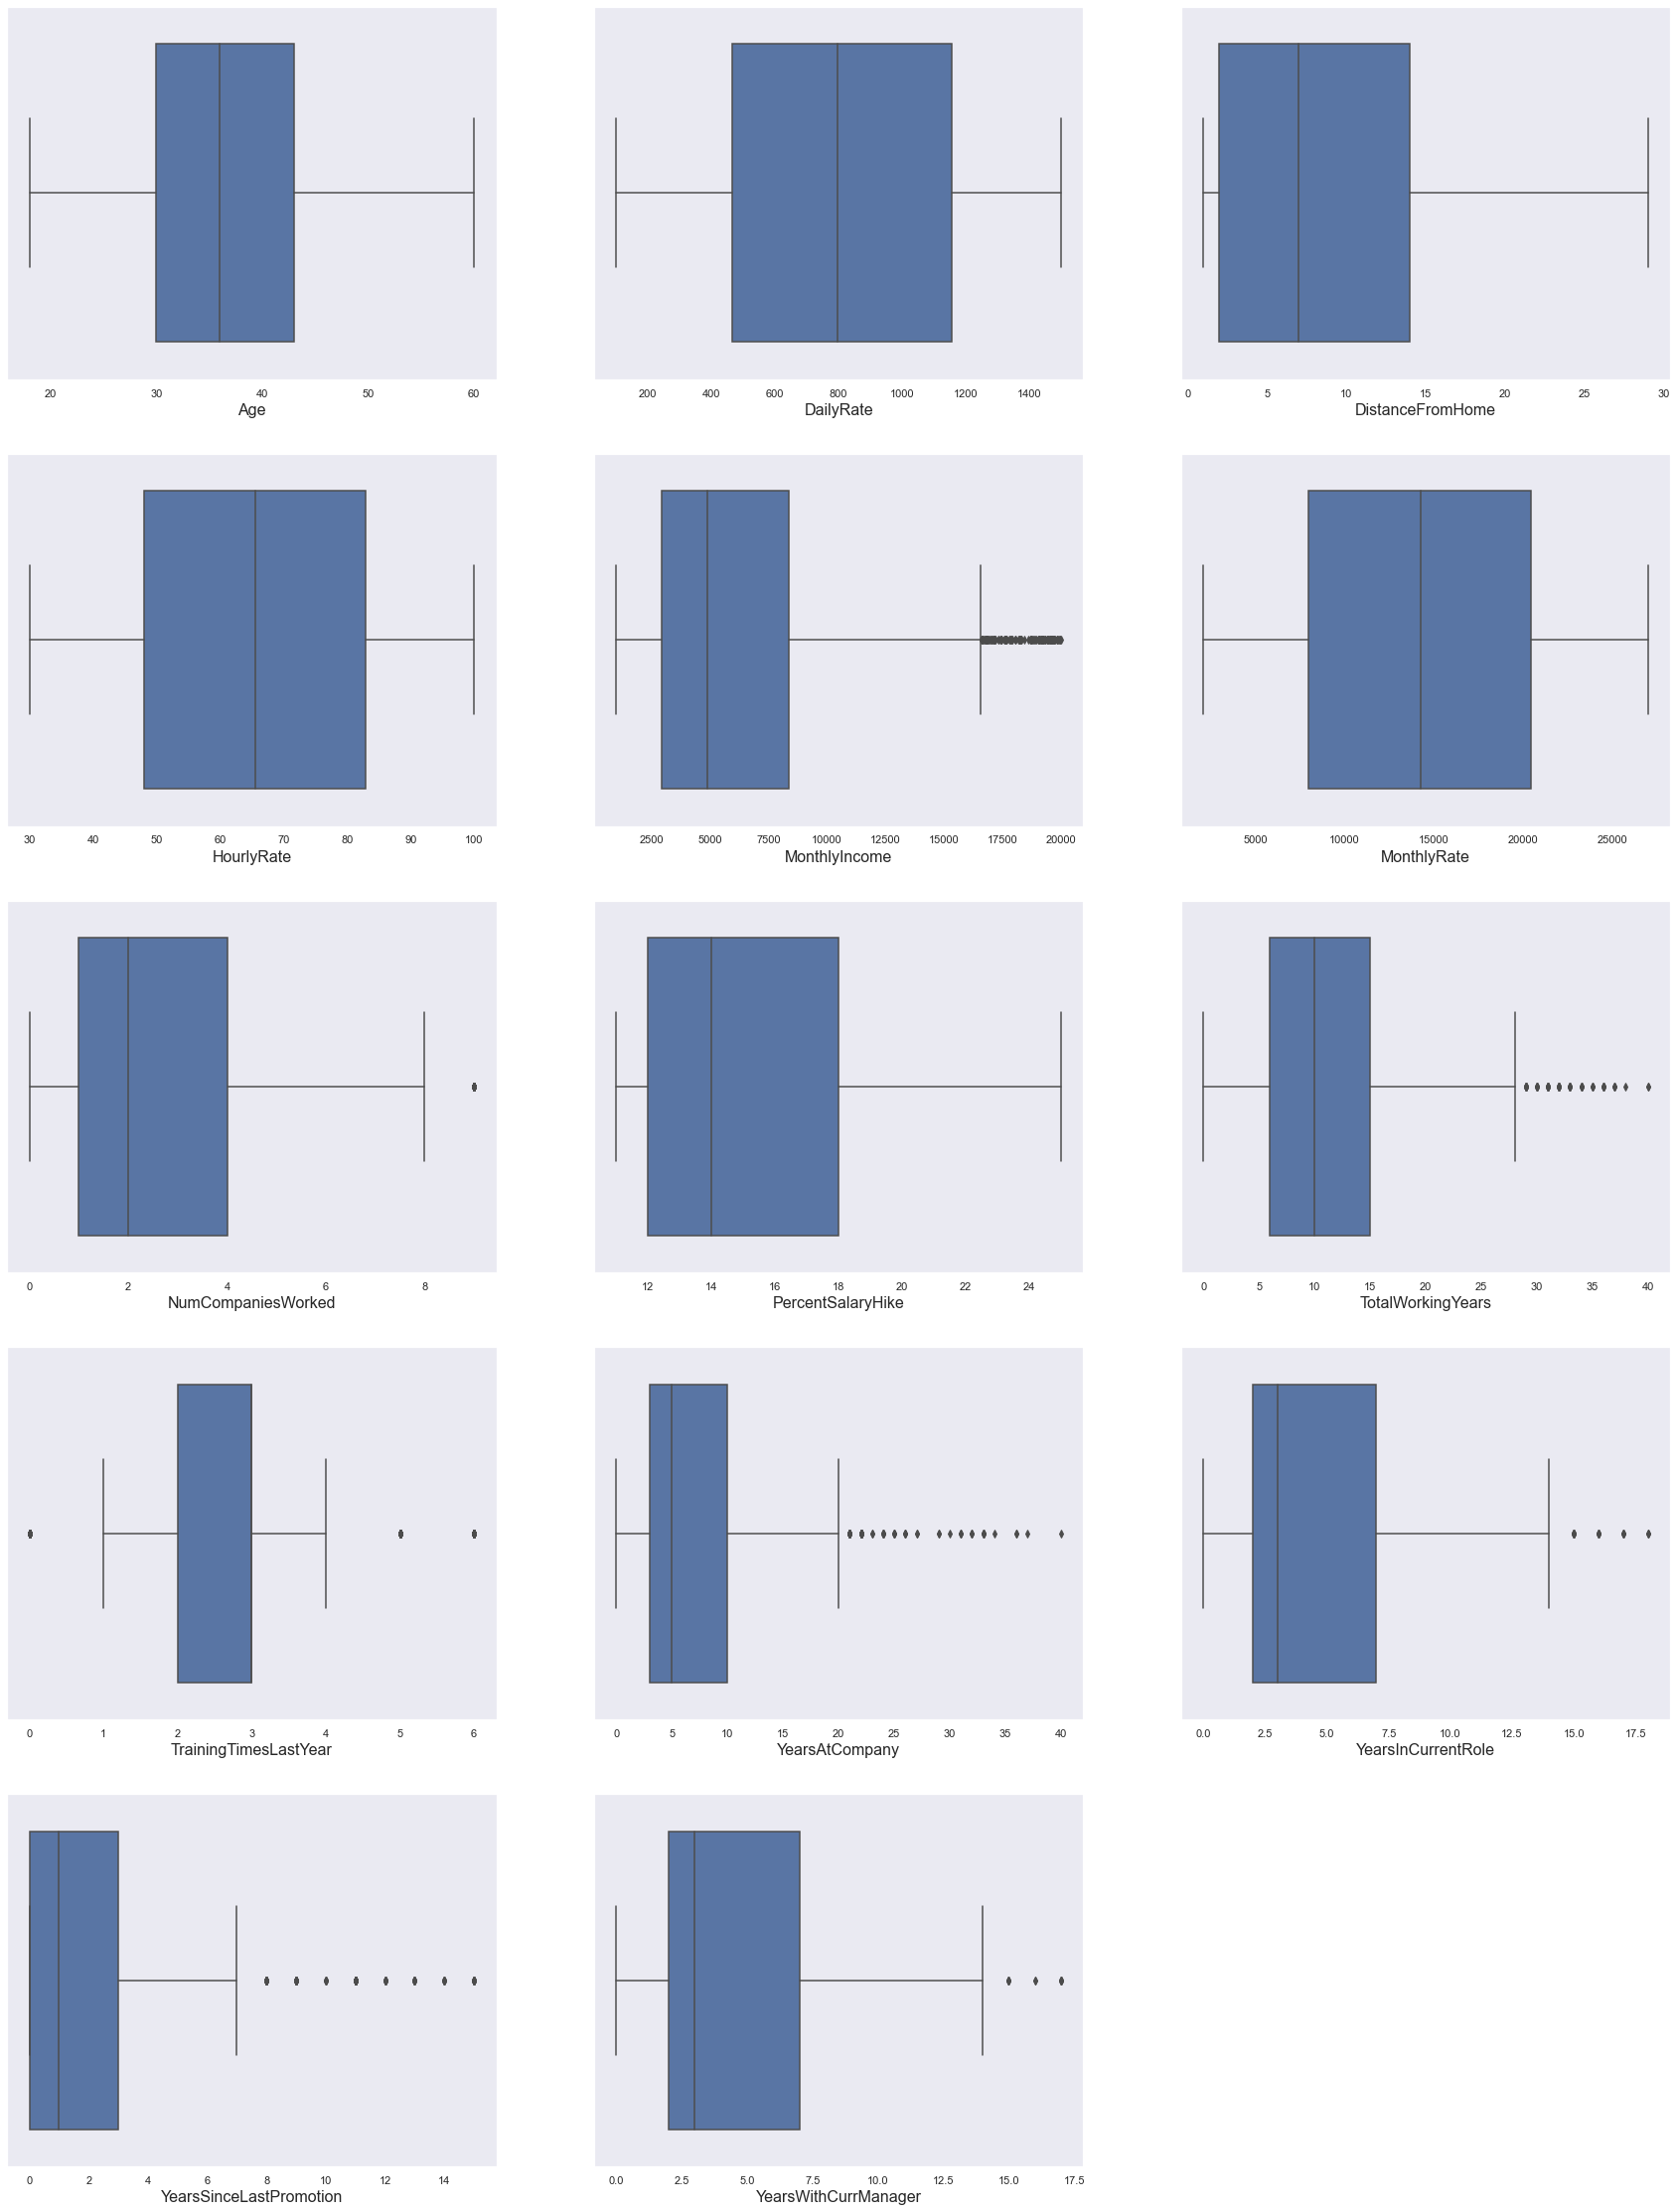

In [13]:
plt.figure(figsize=(30,40))
for i,c in enumerate(df_numbers):
    plt.subplot(5,3,i+1)
    sns.boxplot(data=df_numbers,x=c)
    plt.xlabel(c,fontsize=16)

<h4>Histograms <a id = "histograms" class="anchor"></a></h4>
Shows distribution of each columns

* Age - shows somewhat close to a normal distribution but still shows left skewness
* DailyRate - not quite of a uniform distribution, but close to it.
* DistanceFromHome - left skewed, most people work close to where they live.
* HourlyRate - much like daily rate, not quite uniform, but close to it
* MonthlyIncome - left skewness
* MonthlyRate - much like daily rate, not quite uniform, but close to it

The following columns show left skewness to their distribution:
* NumCompaniesWorked 
* PercentSalaryHike
* TotalWorkingYears
* YearsAtCompany
* YearsInCurrentRole
* YearsSinceLastPromotion
* YearsWithCurrManager


We might need to transform some of the fields using scaling options to that they are in normal distribution, lets look to see if it is needed

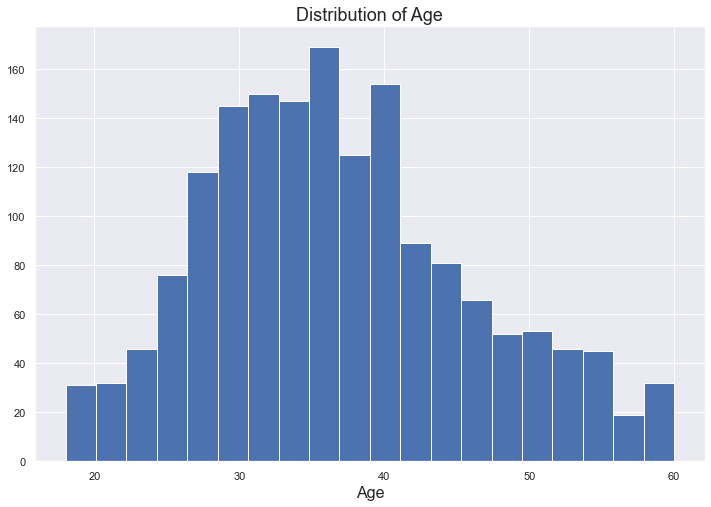

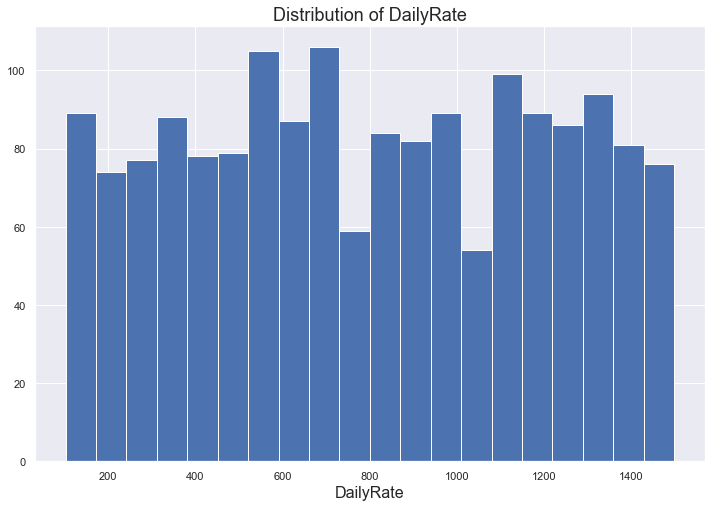

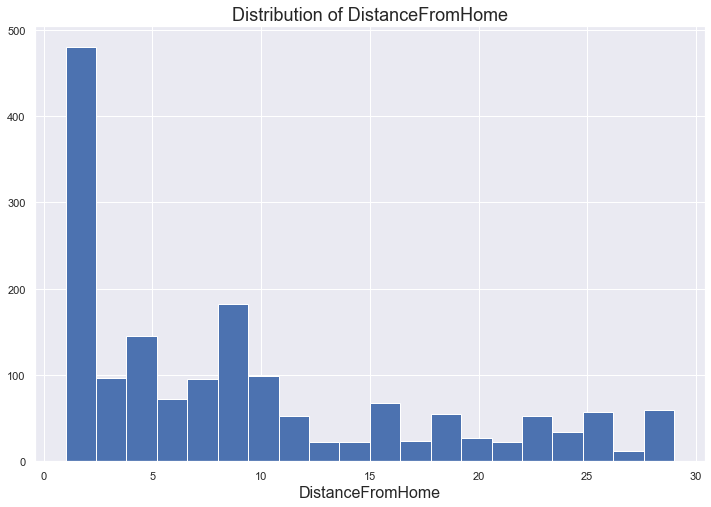

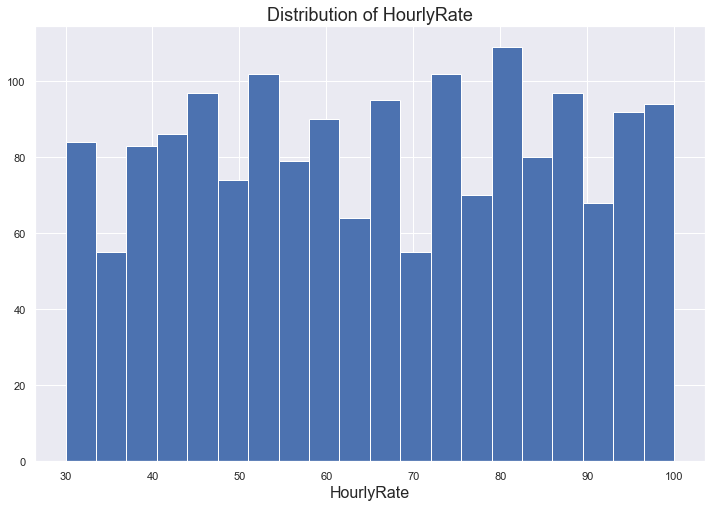

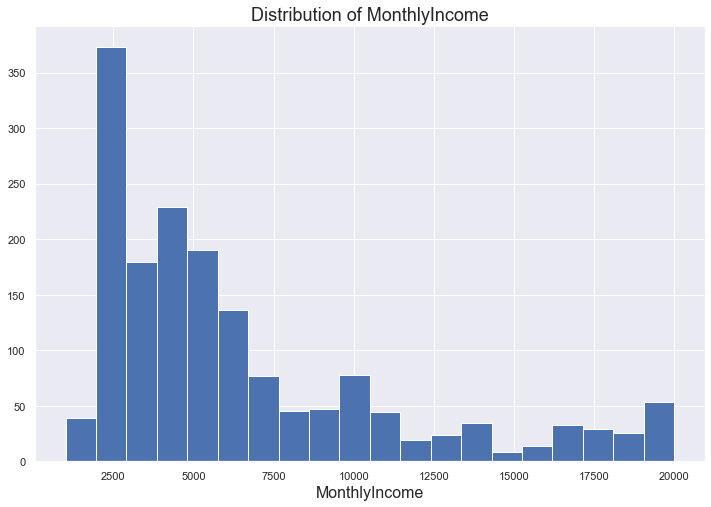

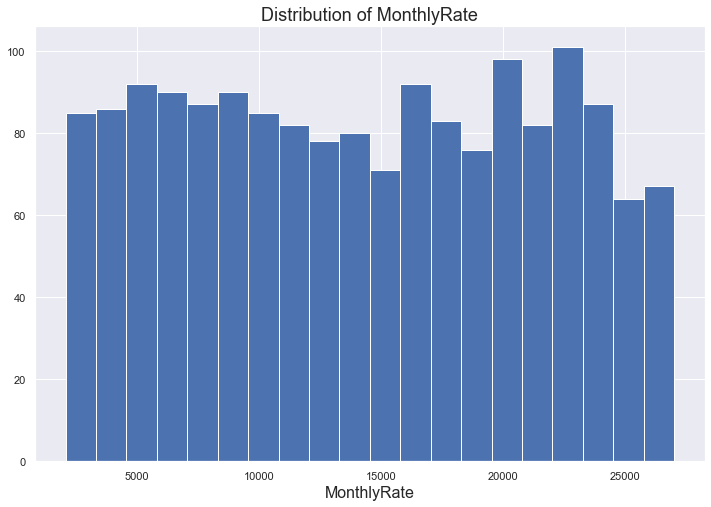

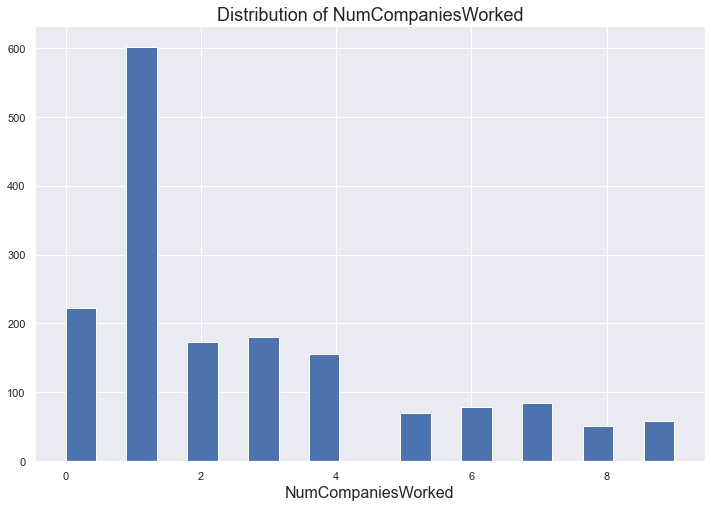

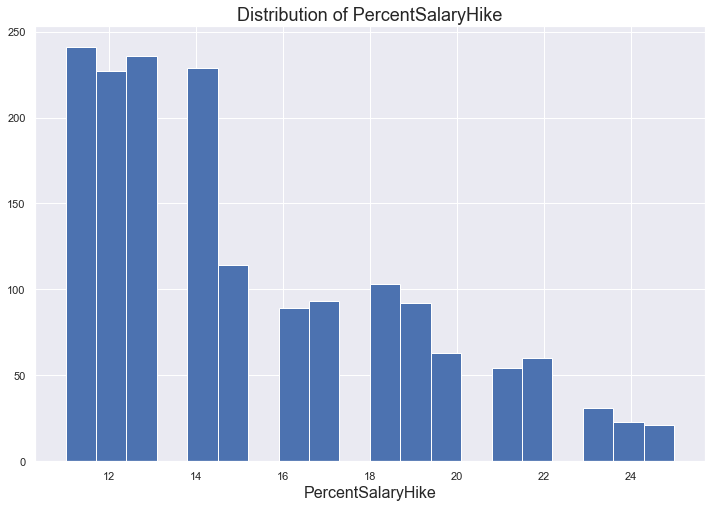

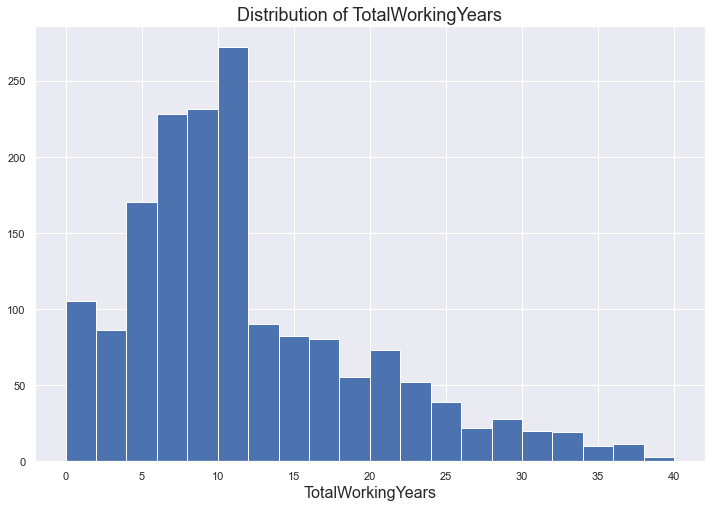

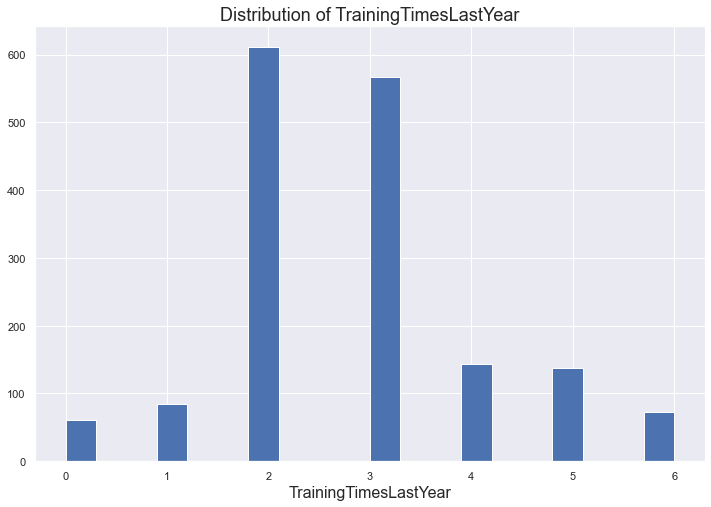

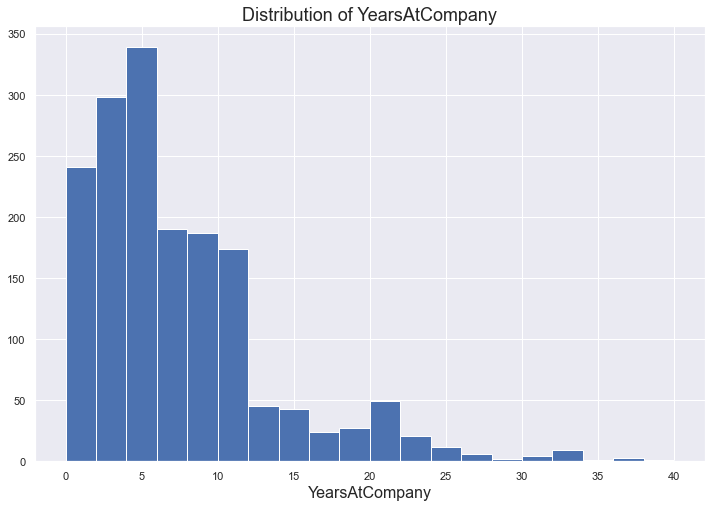

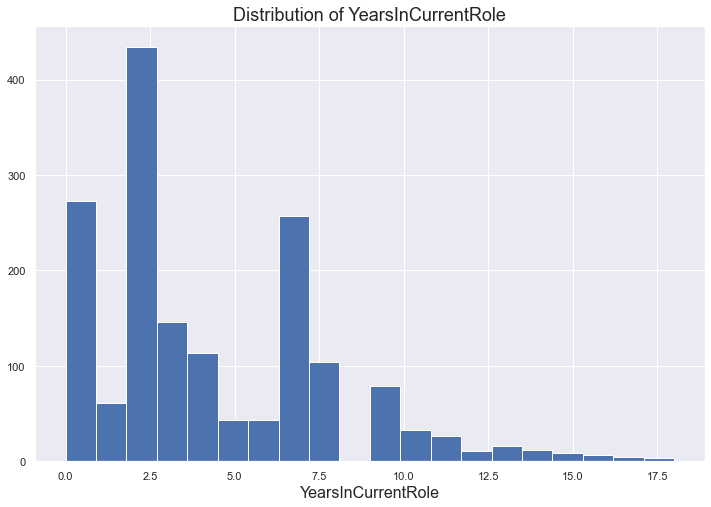

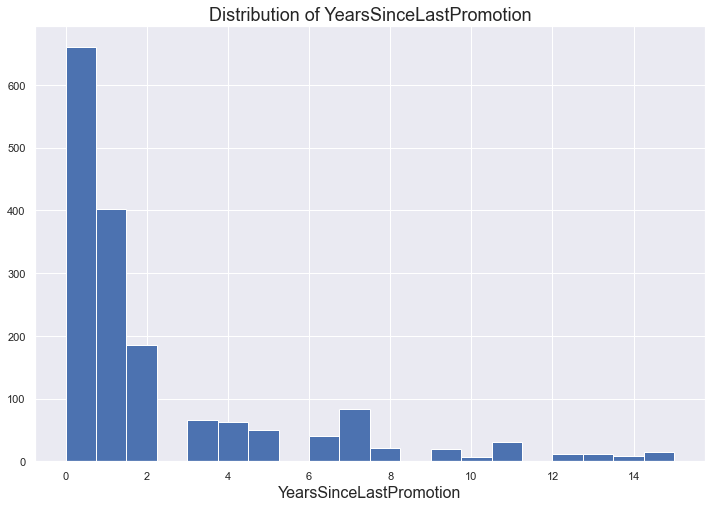

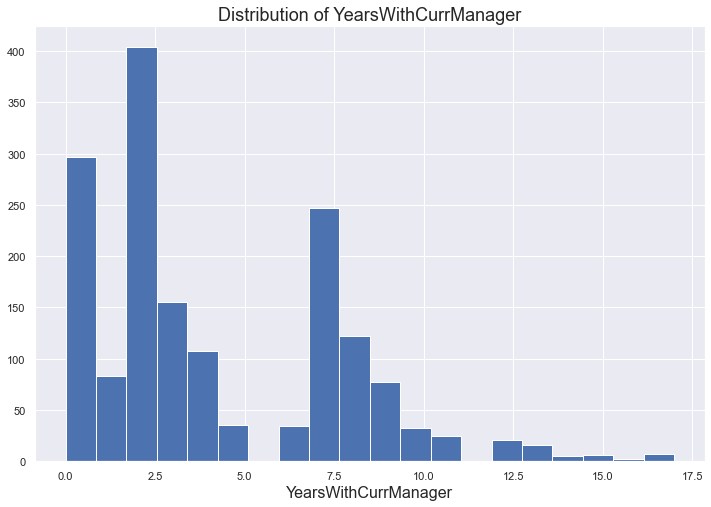

In [14]:
def plot_histogram(data,col,bin_size): 
    plt.figure(figsize=(12,8))
    data[col].hist(bins=bin_size)
    plt.xlabel(col,fontsize=16)
    plt.title('Distribution of {}'.format(col),fontsize=18);
    return

# Plotting Histograms
[plot_histogram(df,c,20) for c in list(cols_number)];
    

##### The following Standard Scaler did not change the distribution from above, so no need to transform the fields

<Figure size 1440x720 with 0 Axes>

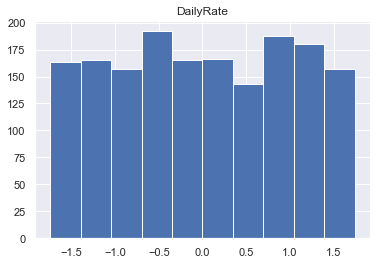

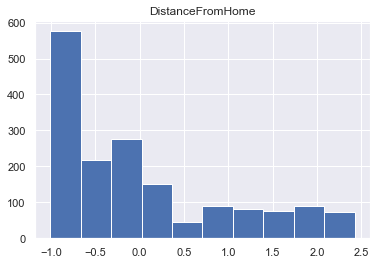

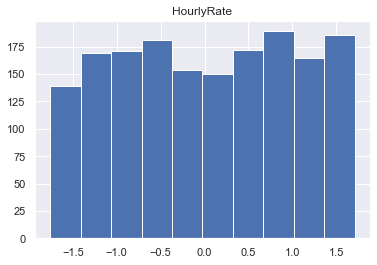

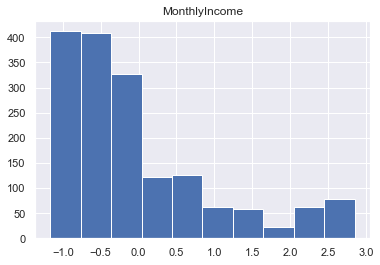

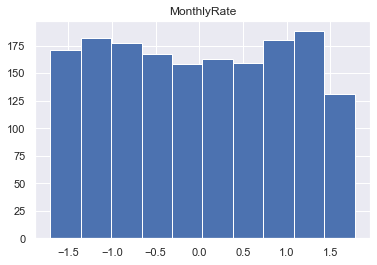

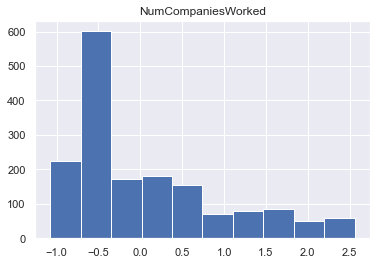

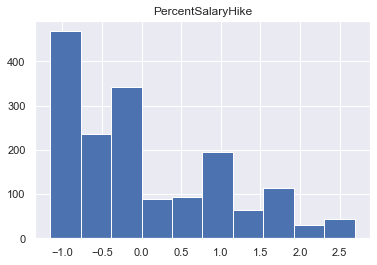

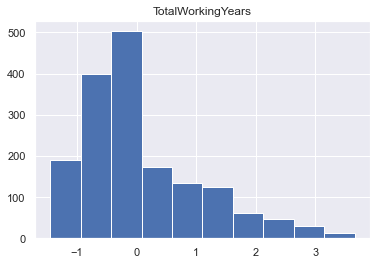

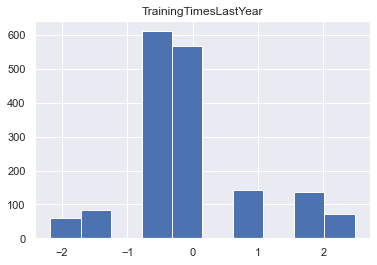

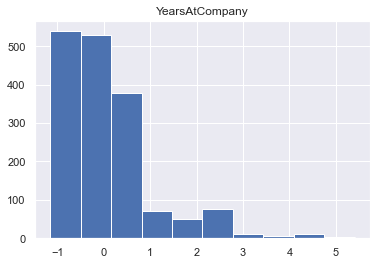

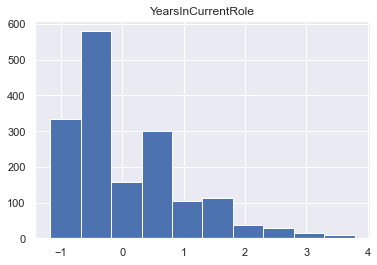

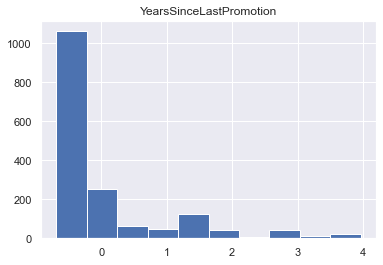

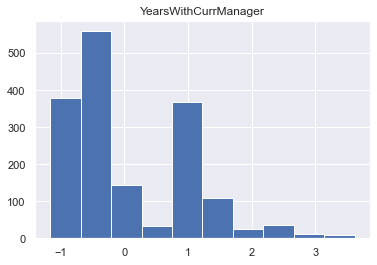

In [15]:
# The following will be transformed by using Standard Scaler
cn = cols_number.values.tolist()
cn.remove('Age')

from numpy import asarray
from sklearn.preprocessing import StandardScaler,MinMaxScaler

plt.figure(figsize=(20,10))
for c in cn:
    x = df1[[c]].values #returns a numpy array
    std_scaler = StandardScaler()
    x_scaled = std_scaler.fit_transform(x)
    g = pd.DataFrame(x_scaled)
    g.hist()
    plt.title(c);

### Plots of Categorical Variables
<h4>Countplots <a id = "countplots" class="anchor"></a></h4>

Here we will plot categorical fields with respect to whether the employee left the company or not

Count of Each Categorical Variable


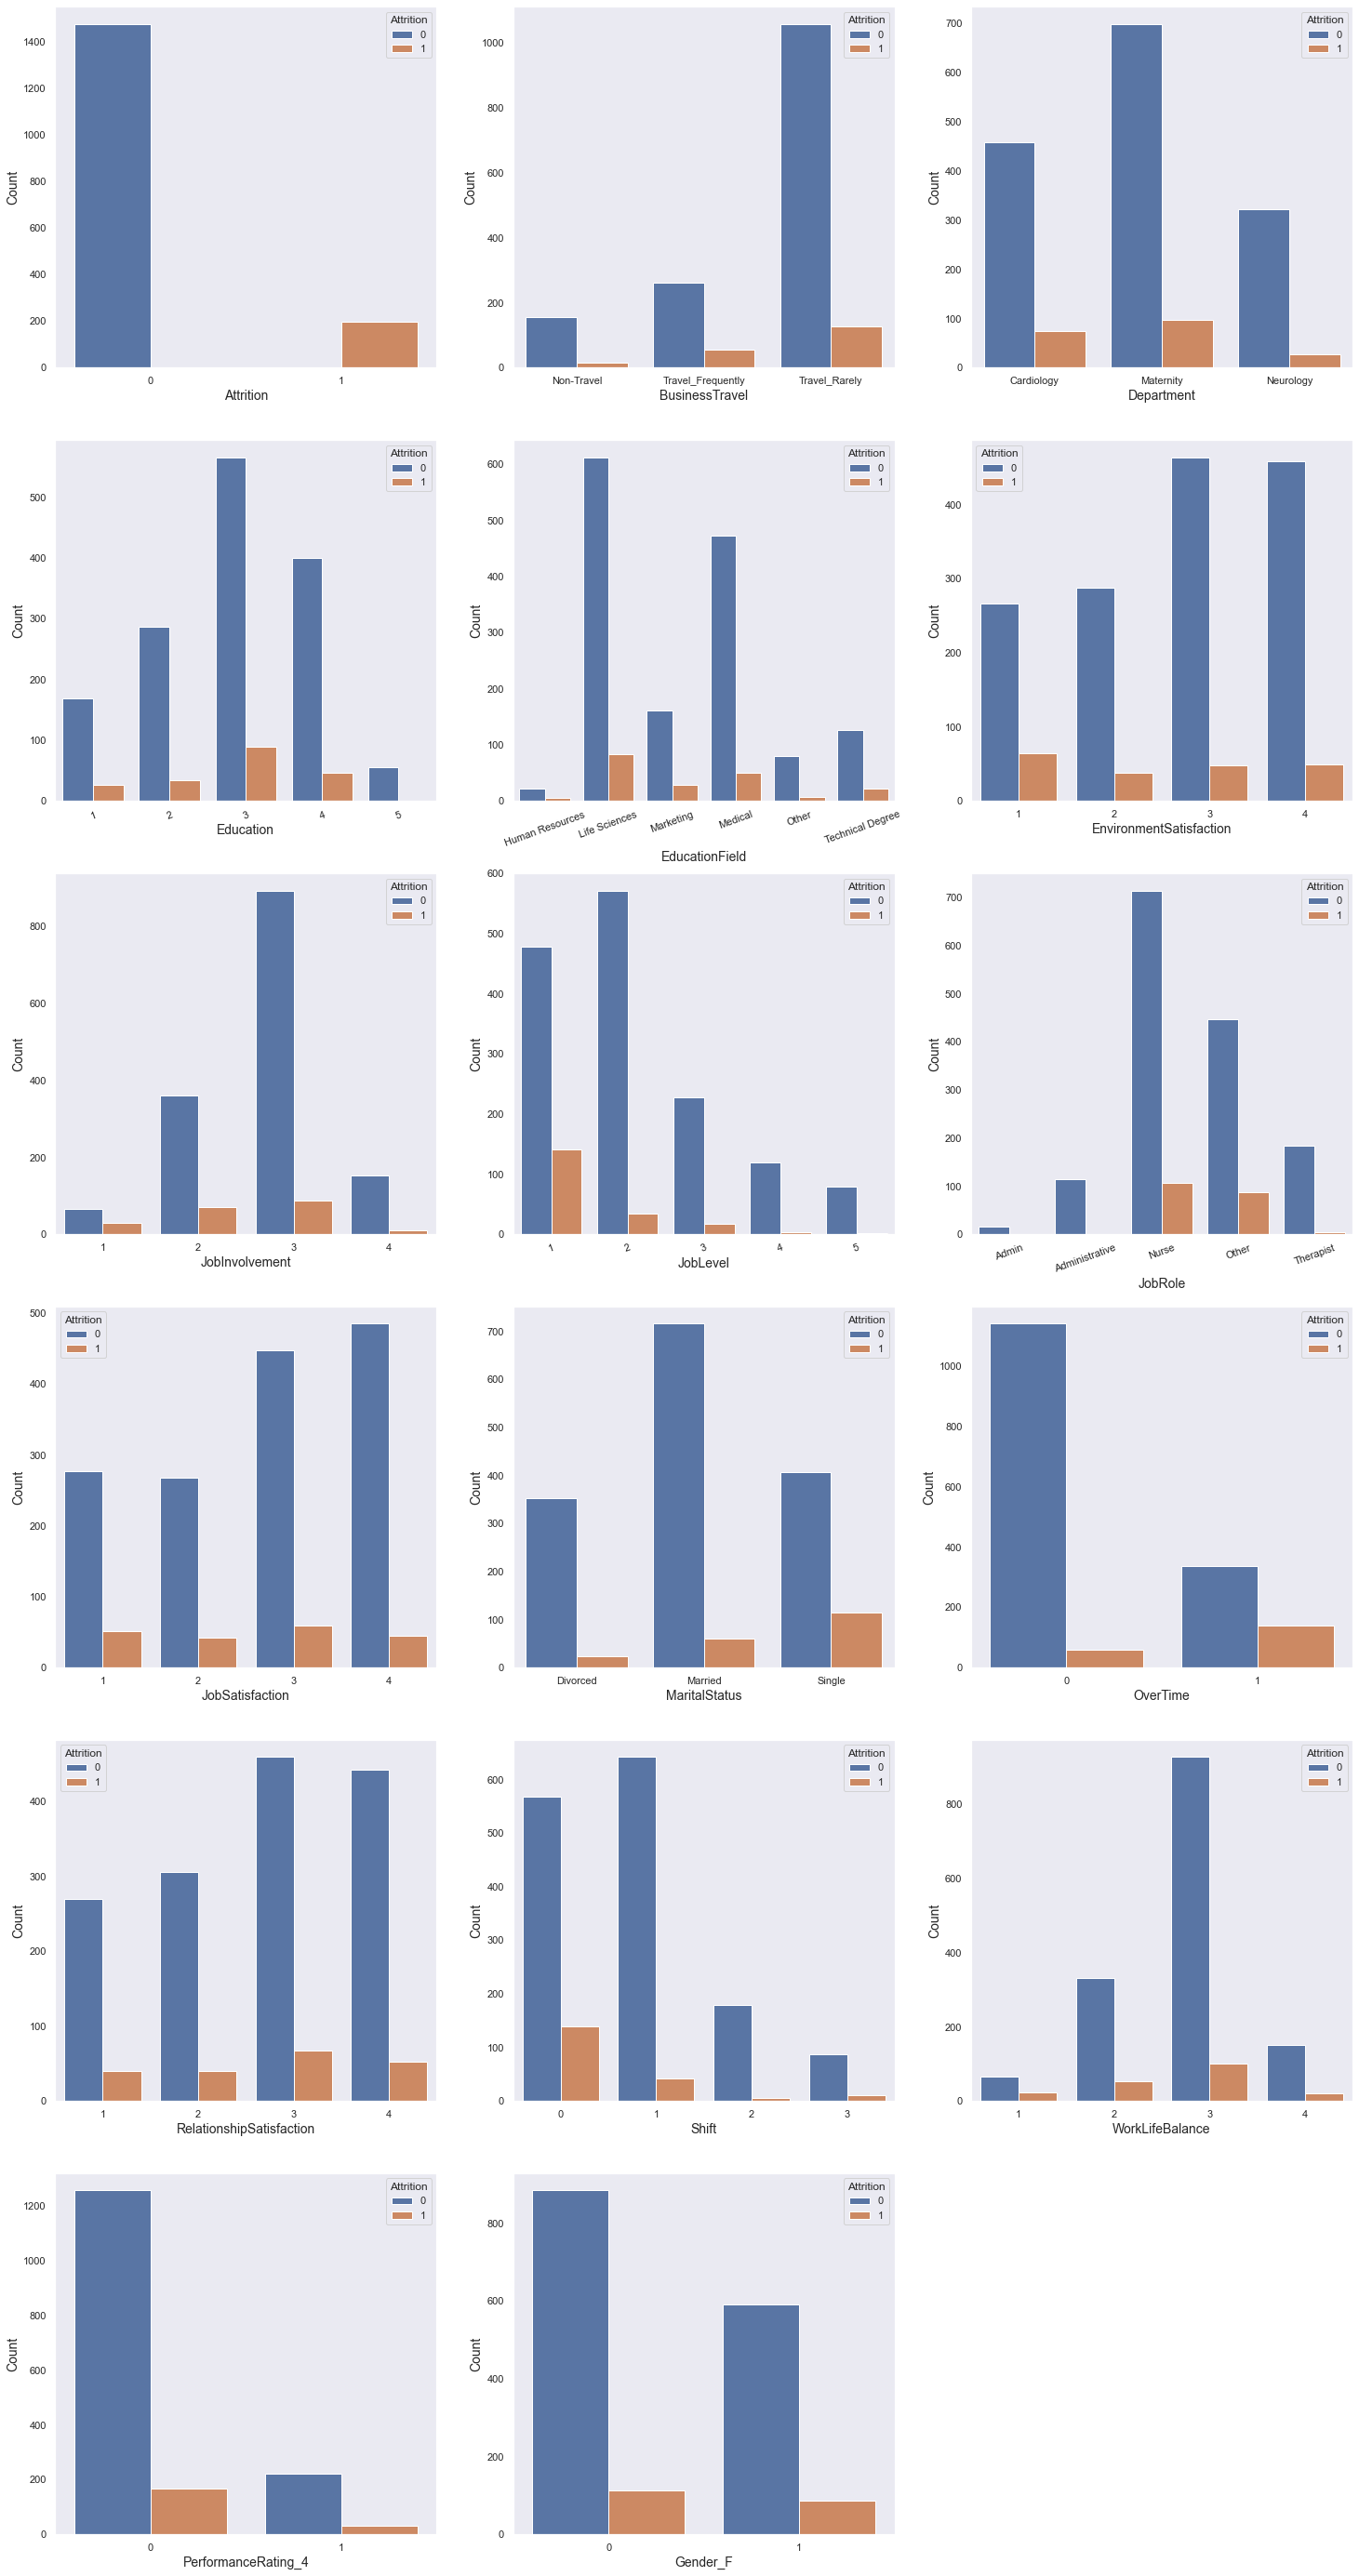

In [16]:
plt.figure(figsize=(25,50))
print ('Count of Each Categorical Variable')
for i,c in enumerate(df_string):
    plt.subplot(6,3,i+1)
    ax = sns.countplot(data=df_string,hue='Attrition',x=c,order=sorted(df_string[c].unique()))
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Count',fontsize=14)
    if df_string[c].nunique()>4:
        plt.xticks(rotation=20)
    else:
        pass

<h2>Exploratory Data Analysis <a id = "eda" class="anchor"></a></h2>
Some of the questions we will tackle are:

1) How do columns (features, independent variables) interact with the dependent variable, attrition?
2) Are there correlation among features?

#### Heatmap

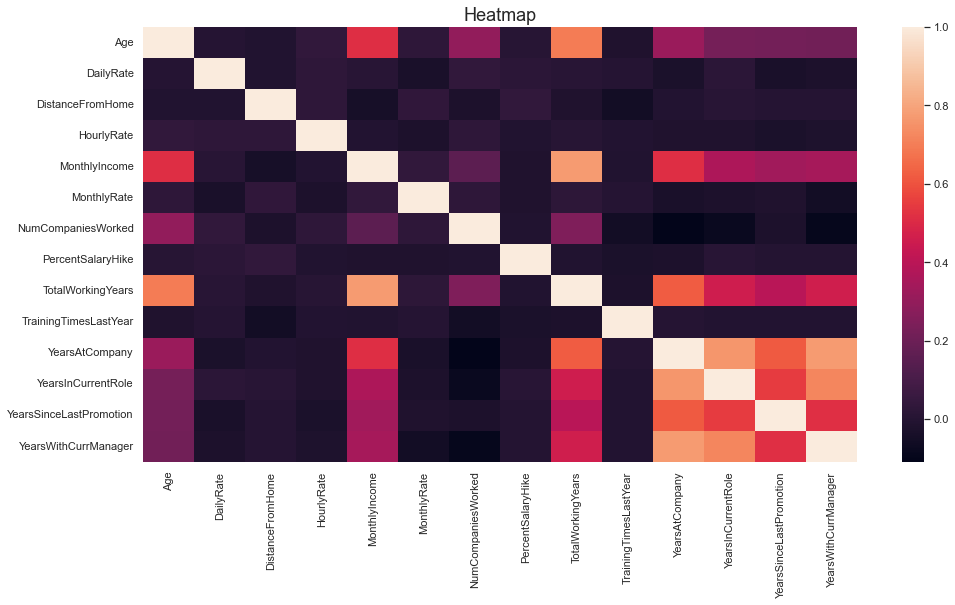

In [17]:
corr = df1.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Heatmap',fontsize=18);

#### Trends

* Years columns (YearsAtCompany) and Totalworkingyears seem to be positively correlated, which makes sense, longer you worked at the company, current role, current manager, the more likely it is you worked longer
* Same goes for the Years features and MonthlyIncome


In [18]:
print ('Percentage of employees that left the workplace is {}%'.format((100*(df1['Attrition'].value_counts()[1]/df1['Attrition'].value_counts().sum())).round(2)))
# There is a class imbalance

Percentage of employees that left the workplace is 11.87%


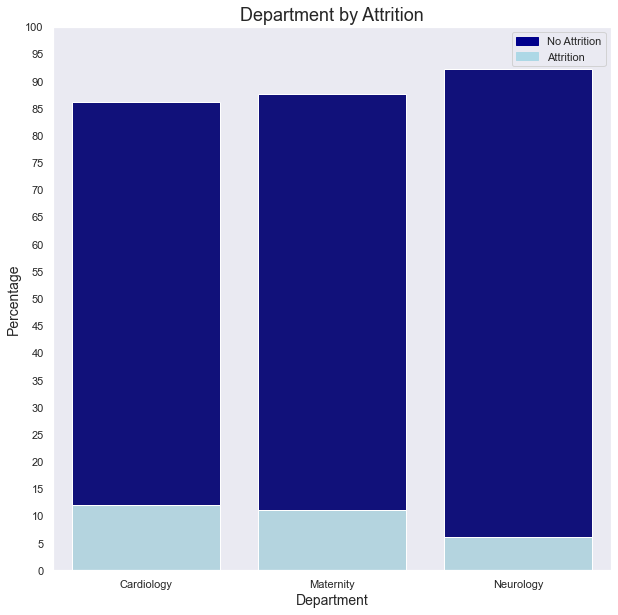

Attrition,Department,No,Yes,No%,Yes%
0,Cardiology,457,74,86.06,11.99
1,Maternity,698,98,87.69,11.09
2,Neurology,322,27,92.26,6.12


In [19]:
def interaction(col1,col2):
    '''
    Creating a Pivot Table based on col1 and col2 (Attrition), and then graphing the values using a stacked bar chart
    col1: dependent variable/field/feature
    col2: it is generic, but when calling the function, it will be Attrition
    '''
    pt = df.groupby([col1,col2])['EmployeeID'].count().unstack()
    pt['No%'] = round(100*(pt['No']/pt.sum(axis=1)),2)
    pt['Yes%'] = round(100*(pt['Yes']/pt.sum(axis=1)),2)
    # set the figure size
    plt.figure(figsize=(10, 10))
    # Barcharts for No% and Yes%
    bar1 = sns.barplot(x=pt.index, y="No%", data=pt, color='darkblue')
    bar2 = sns.barplot(x=pt.index, y="Yes%", data=pt, color='lightblue')
    # add legend
    top_bar = mpatches.Patch(color='darkblue', label='No Attrition')
    bottom_bar = mpatches.Patch(color='lightblue', label='Attrition')
    # changing xticks
    plt.yticks(np.arange(0,101,5))
    plt.legend(handles=[top_bar, bottom_bar])
    plt.title('{} by {}'.format(col1,col2),fontsize=18)
    plt.ylabel('Percentage',fontsize=14)
    plt.xlabel(col1,fontsize=14)
    # show the graph
    plt.show()
    
    return pt.reset_index()

pt0 = interaction(col_string[2],col_string[0])
pt0

In [209]:
df1['JobRole'].unique()

array(['Nurse', 'Other', 'Therapist', 'Administrative', 'Admin'],
      dtype=object)

In [207]:
df1.columns

Index(['EmployeeID', 'Age', 'Attrition', 'BusinessTravel', 'DailyRate',
       'Department', 'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'RelationshipSatisfaction', 'Shift', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'PerformanceRating_4', 'Gender_F'],
      dtype='object')

<Figure size 1440x720 with 0 Axes>

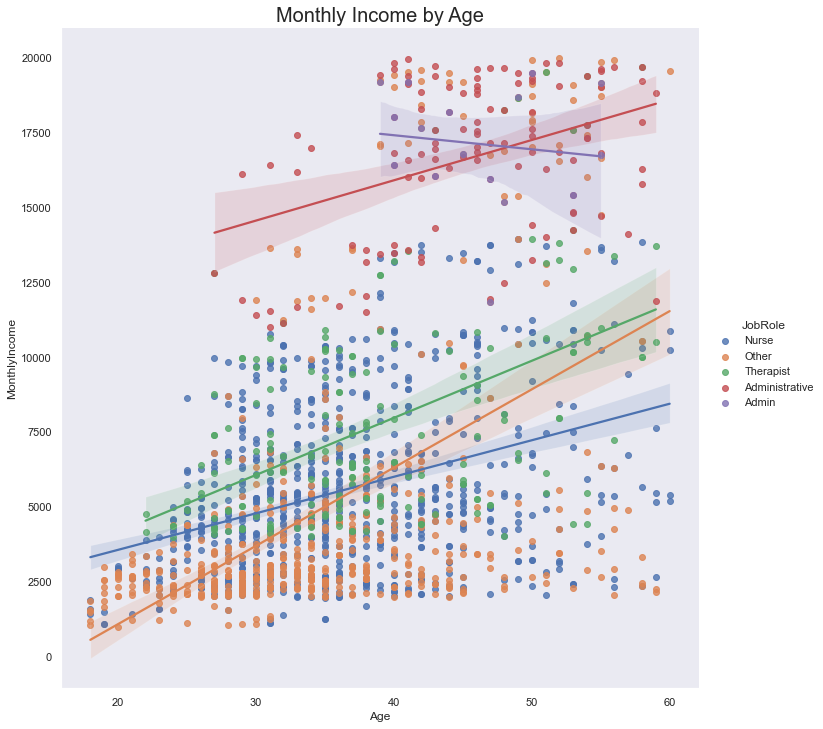

In [216]:
plt.figure(figsize=(20,10))
sns.pairplot(x_vars='Age',y_vars='MonthlyIncome',data=df1,size=10,hue='JobRole',kind="reg")
plt.title('Monthly Income by Age',fontsize=20)
plt.show();

<h2>Modeling <a id = "modeling" class="anchor"></a></h2>
We will cover the following models and see how they stack up

* Logistic Regression
* Random Forest
* Extra Trees
* Gradient Boosting
* XGBoost

first thing first, we will need to convert some features to dummy variables, we will do this by using the pandas function getdummies

#### Creating dataframe of dummy variables
Used [this](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8) as an example for dummy variables and RFE.


In [21]:
df2 = df1.copy()
# This is the dependent variables
y = df2['Attrition']

df2 = df2.drop(['EmployeeID','Attrition'],axis=1)

# Grabbing the string columns to convert to dummy variables
cat_vars=[x for x in col_string if (x in df2) and (x not in ['PerformanceRating_4','Gender_F'])]
# copying dataframe
data = df2.copy()
# creating dummy for each variable and then joinin with copied df
for var in cat_vars:
    cat_list='var'+'_'+var
    #print (cat_list)
    cat_list = pd.get_dummies(data[var], prefix=var)
    data=data.join(cat_list)

data_vars = data.columns.values.tolist()
cols_keep = [i for i in data_vars if i not in cat_vars]
data_final=data[cols_keep]
data_final.columns.values

array(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'PerformanceRating_4', 'Gender_F',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Cardiology',
       'Department_Maternity', 'Department_Neurology', 'Education_1',
       'Education_2', 'Education_3', 'Education_4', 'Education_5',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'EnvironmentSatisfaction_1', 'EnvironmentSatisfaction_2',
       'EnvironmentSatisfaction_3', 'EnvironmentSatisfaction_4',
       'JobInvolvement_1', 'JobInvolvement_2', 'JobInvolvemen

#### Creating Training and Test Data

In [22]:
# Creating Train/Test split
X_train, X_test, y_train, y_test = train_test_split(data_final, y, test_size=0.3, random_state=25)

data_final_vars=data_final.columns.values.tolist()
X_cols=[i for i in data_final_vars if i not in y]
X_train = X_train[X_cols]

#### Recursive Feature Elimination

* Explain what this is

In [24]:
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(X_train, pd.DataFrame(y_train).values.ravel())
#print(rfe.support_)
#print(rfe.ranking_)

rfe_results = pd.DataFrame([X_cols,rfe.support_,rfe.ranking_],index=['Column','Support','Ranking']).T
rfe_columns = rfe_results[rfe_results['Support']==True]['Column'].values.tolist()
rfe_results[rfe_results['Support']==True]

,Column,Support,Ranking
11,YearsInCurrentRole,True,1
14,PerformanceRating_4,True,1
17,BusinessTravel_Travel_Frequently,True,1
18,BusinessTravel_Travel_Rarely,True,1
19,Department_Cardiology,True,1
22,Education_1,True,1
24,Education_3,True,1
25,Education_4,True,1
26,Education_5,True,1
27,EducationField_Human Resources,True,1


#### Explain
* Cross Val
* Gridsearch
* AUC

In [173]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [123]:
def skf_cross_val_score(model,ind_vars_df,dep_vars):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)
    m_cvs = cross_val_score(model,ind_vars_df,dep_vars,cv=skf,n_jobs=-1)
    print("Average Cross Validation score :{}".format(m_cvs.mean()))
    return m_cvs

In [121]:
def false_negative_pct(ytest,ypred):
    '''
    Calculating False Negatives/False Positives for Classifiers
        ytest: Actual dependent variable
        ypred: Prediction of dependent variable after running the prediction method for a given model
    returns:
        dataframe of actual and predicted y values and creates a flag for TP,TN,FP,FN
    '''
    j = pd.DataFrame([ytest.values,ypred],index=['Actual','Predicted']).T
    j.loc[(j['Actual']=='0') & (j['Predicted']=='0'),'Type'] = 'TN'
    j.loc[(j['Actual']=='1') & (j['Predicted']=='1'),'Type'] = 'TP'
    j.loc[(j['Actual']=='0') & (j['Predicted']=='1'),'Type'] = 'FP'
    j.loc[(j['Actual']=='1') & (j['Predicted']=='0'),'Type'] = 'FN'
    fn_pct = round(j[j['Type']=='FN'].shape[0]/j.shape[0],4)
    fp_pct = round(j[j['Type']=='FP'].shape[0]/j.shape[0],4)    
    print ('False Negative:',fn_pct)
    print ('False Positive:',fp_pct)
    return j

<h3>Logistic Regression <a id = "lr" class="anchor"></a></h3>

By default, it is L2 Penalty (Lasso)

Logistic Regression Accuracy Score: 0.877


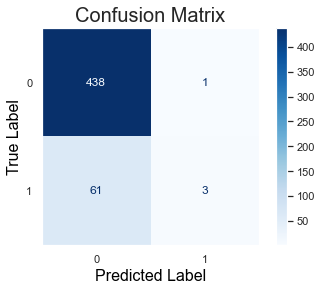

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       439
           1       0.75      0.05      0.09        64

    accuracy                           0.88       503
   macro avg       0.81      0.52      0.51       503
weighted avg       0.86      0.88      0.83       503



In [183]:
lr = LogisticRegression(random_state=25)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test,y_pred).round(3))
lr_cm = confusion_matrix(y_test,y_pred)

color = 'black'
disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm,display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix',fontsize=20)
plt.xlabel('Predicted Label', color=color,fontsize=16)
plt.ylabel('True Label', color=color,fontsize=16)
plt.show();
print(classification_report(y_test, y_pred))

In [177]:
lr_y_score = lr.decision_function(X_test)
print ("AUC Score is:",roc_auc_score(y_test, lr_y_score))

AUC Score is: 0.8113432517084282


In [120]:
false_negative_pct(y_test,y_pred)

False Negative: 0.1213
False Positive: 0.002


,Actual,Predicted,Type
0,0,0,TN
1,0,0,TN
2,0,0,TN
3,0,0,TN
4,0,0,TN
...,...,...,...
498,0,0,TN
499,0,0,TN
500,0,0,TN
501,0,0,TN


In [168]:
# Coefficients of Features
lrc = pd.DataFrame([X_train.columns.values.tolist(),lr.coef_[0]],index=['Feature','Coefficients']).T.sort_values(by='Coefficients',ascending=False)
lrc.head(10)

,Feature,Coefficients
2,DistanceFromHome,0.045221
6,NumCompaniesWorked,0.036016
59,OverTime_1,0.027627
64,Shift_0,0.014918
57,MaritalStatus_Single,0.013952
12,YearsSinceLastPromotion,0.009523
41,JobLevel_1,0.009397
38,JobInvolvement_2,0.008845
7,PercentSalaryHike,0.008776
33,EnvironmentSatisfaction_1,0.007901


Logistic Regression Accuracy Score: 0.907


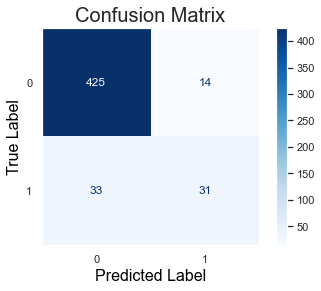

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       439
           1       0.69      0.48      0.57        64

    accuracy                           0.91       503
   macro avg       0.81      0.73      0.76       503
weighted avg       0.90      0.91      0.90       503



In [184]:
# With RFE
lr1 = LogisticRegression(random_state=25)
lr1.fit(X_train[rfe_columns],y_train)
y_pred1 = lr1.predict(X_test[rfe_columns])
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test,y_pred1).round(3))
lr_cm1 = confusion_matrix(y_test,y_pred1)

color = 'black'
disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm1,display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix',fontsize=20)
plt.xlabel('Predicted Label', color=color,fontsize=16)
plt.ylabel('True Label', color=color,fontsize=16)
plt.show();
print(classification_report(y_test, y_pred1))

In [182]:
lr_y_score1 = lr1.decision_function(X_test[rfe_columns])
print ("AUC Score is:",roc_auc_score(y_test, lr_y_score1))

AUC Score is: 0.9164827733485195


In [116]:
false_negative_pct(y_test,y_pred1)

False Negative: 0.0656
False Positive: 0.0278


,Actual,Predicted,Type
0,0,0,TN
1,0,0,TN
2,0,0,TN
3,0,0,TN
4,0,0,TN
...,...,...,...
498,0,0,TN
499,0,0,TN
500,0,0,TN
501,0,0,TN


In [169]:
# Coefficients of Features
lrc1 = pd.DataFrame([X_train.columns.values.tolist(),lr1.coef_[0]],index=['Feature','Coefficients']).T.sort_values(by='Coefficients',ascending=False)
lrc1.head(10)

,Feature,Coefficients
21,Department_Neurology,1.815316
29,EducationField_Marketing,1.74111
9,TrainingTimesLastYear,1.499733
17,BusinessTravel_Travel_Frequently,1.324988
34,EnvironmentSatisfaction_2,1.100556
31,EducationField_Other,1.089405
2,DistanceFromHome,0.936252
4,MonthlyIncome,0.914783
25,Education_4,0.888764
24,Education_3,0.818998


#### Logistic Regression Analysis
Lower left is False Negative  - prediction no attrition but person left. I would find this to be worse as it is predicted the employee would not leave, but ended up leaving. Perhaps if the company wanted the employee to stay they could have made changes, paid more, to pursuade the employee from leaving. 

There is also a class imbalance of Attrition that will need to be addressed.

<h3>Random Forest<a id = "rf" class="anchor"></a></h3>

* Explain Random Forest

Steps:

* Fit/Predict
* Crossvalidation
* Confusion Matrix
* AUC
* Feature Importances
* Analysis

Logistic Regression Accuracy Score: 0.9065606361829026
Average Cross Validation score :0.9104897348160821


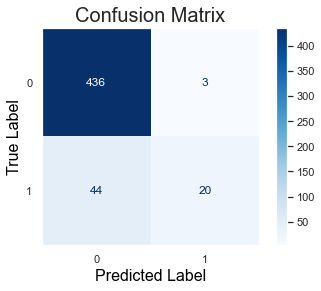

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       439
           1       0.87      0.31      0.46        64

    accuracy                           0.91       503
   macro avg       0.89      0.65      0.70       503
weighted avg       0.90      0.91      0.89       503



In [126]:
rf = RandomForestClassifier(random_state=25,n_jobs=-1,class_weight='balanced')
rf.fit(X_train,y_train)
rfy_pred = rf.predict(X_test)
print ('Logistic Regression Accuracy Score:',accuracy_score(y_test,rfy_pred))
rf_cm = confusion_matrix(y_test,rfy_pred)

# Crossvalidation using Stratified K Fold - Explain why this is useful
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)
rfcvs = cross_val_score(rf,data_final,y,cv=skf,n_jobs=-1)
print("Average Cross Validation score :{}".format(rfcvs.mean()))

color = 'black'
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm,display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix',fontsize=20)
plt.xlabel('Predicted Label', color=color,fontsize=16)
plt.ylabel('True Label', color=color,fontsize=16)
plt.show();
print(classification_report(y_test, rfy_pred))

In [117]:
false_negative_pct(y_test,rfy_pred)

False Negative: 0.0855
False Positive: 0.008


,Actual,Predicted,Type
0,0,0,TN
1,0,0,TN
2,0,0,TN
3,0,0,TN
4,0,0,TN
...,...,...,...
498,0,0,TN
499,0,0,TN
500,0,0,TN
501,0,0,TN


In [200]:
# positive class for rf.predict_proba
print ("AUC Score is:",roc_auc_score(y_test,rf.predict_proba(X_test)[:,1] ))

AUC Score is: 0.9058406890660592


In [138]:
# Feature Importances
rf_fi = pd.DataFrame([X_train.columns.values.tolist(),rf.feature_importances_.tolist()],index=['Feature','Feature Importance']).T
rf_fi.sort_values(by='Feature Importance',ascending=False).head(10)

,Feature,Feature Importance
58,OverTime_0,0.106313
59,OverTime_1,0.077333
0,Age,0.07248
4,MonthlyIncome,0.056636
8,TotalWorkingYears,0.052358
10,YearsAtCompany,0.046715
5,MonthlyRate,0.033264
13,YearsWithCurrManager,0.031888
1,DailyRate,0.031284
2,DistanceFromHome,0.030491


<h3>Extra Trees<a id = "et" class="anchor"></a></h3>

* Explain Extra Trees

<h3>Gradient Boosting<a id = "gbm" class="anchor"></a></h3>

* Explain Gradient Boosting